In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [32]:
def calc_normalMap(depth_map):
    """calculate normal map from depth map

    Args:
        depth_map (ndarray): depth map

    Returns:
        ndarray: normal map
    """
    d_im = depth_map.astype("float64")
    zy, zx = np.gradient(d_im)  
    # You may also consider using Sobel to get a joint Gaussian smoothing and differentation
    # to reduce noise
    #zx = cv2.Sobel(d_im, cv2.CV_64F, 1, 0, ksize=5)     
    #zy = cv2.Sobel(d_im, cv2.CV_64F, 0, 1, ksize=5)

    normal = np.dstack((-zx, -zy, np.ones_like(d_im)))
    n = np.linalg.norm(normal, axis=2)
    normal[:, :, 0] /= n
    normal[:, :, 1] /= n
    normal[:, :, 2] /= n

    # offset and rescale values to be in 0-255
    normal += 1
    normal /= 2
    # if show, comment
    normal *= 255
    # cv2.imwrite("normal.png", normal[:, :, ::-1])
    return normal[:,:,::-1].copy()


In [2]:
def add_noise_Guass(img, mean=0, var=0.01):  # 添加高斯噪声
    img_copy = img.copy()
    img = (img / 255).astype(np.float64)
    noise = np.random.normal(mean, var ** 0.5, img.shape)
    out_img = img + noise
    out_img = np.clip(out_img, 0.0, 1.0)
    out_img[img_copy==0] = 0
    out_img = out_img * 255
    return out_img.astype(np.uint8)

In [8]:
path = '/home/rz/data/lock3dface/dataset_1028_new_no_aug/train_set/001_Kinect_FE_1DEPTH/01_depth_normal.png'
img = cv.imread(path)
img = img[:, :, 0, None]
img.shape
# normal = calc_normalMap(img[:, :, 0]).astype(np.uint8)
# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(img, cmap='gray')
# plt.subplot(1, 2, 2)
# plt.imshow(normal)

(128, 128, 1)

(128, 128, 3)


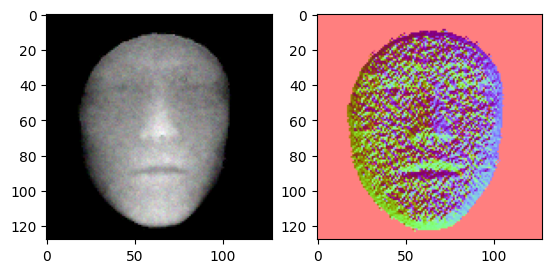

In [49]:
img_noisy = add_noise_Guass(img, var=0.001)
print(img_noisy.shape)
normal_noisy = calc_normalMap(img_noisy[:, :, 0]).astype(np.uint8)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img_noisy, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(normal_noisy)

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import datasets
import random
from torchvision import transforms
from PIL import Image
from utils import to_pixel_samples

In [2]:
def resize_fn(img, size):
    return transforms.ToTensor()(
        transforms.Resize(size, Image.BICUBIC)(
            transforms.ToPILImage()(img)))

In [3]:
spec = {
    'name': 'image-folder',
    'args': {
        'datafile': 'datafiles/lock3dface_test.txt',
        'augment': True,
        'repeat': 1
    }
}
dataset = datasets.make(spec)

In [4]:
x1, x2 = dataset[0]
x1.shape, x2.shape

(torch.Size([1, 128, 128]), torch.Size([1, 128, 128]))

In [5]:
def collect_fn(batch):
    noisy_imgs = []
    hr_coords, hr_gts, cells = [], [], []
    # 同一个batch进行相同的降采样
    s = random.uniform(1.0, 4.0)
    for data in batch:
        img_noisy, img_ori = data
        # downsample
        w_hr = img_ori.shape[-1]
        w_lr = round(w_hr / s)
        img_noisy_lr = resize_fn(img_noisy, w_lr)
        hr_coord, hr_gt = to_pixel_samples(img_ori)
        cell = torch.ones_like(hr_coord)
        cell[:, 0] *= 2 / w_hr
        cell[:, 1] *= 2 / w_hr
        hr_coords.append(hr_coord)
        hr_gts.append(hr_gt)
        cells.append(cell)

        noisy_imgs.append(img_noisy_lr)
    noisy_imgs = torch.stack(noisy_imgs, dim=0)
    hr_coords = torch.stack(hr_coords, dim=0)
    hr_gts = torch.stack(hr_gts, dim=0)
    cells = torch.stack(cells, dim=0)
    return {
        'inp': noisy_imgs,
        'coord': hr_coords,
        'cell': cells,
        'gt': hr_gts,
    }

In [6]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collect_fn)

In [7]:
batch = next(iter(dataloader))
batch['inp'].shape, batch['gt'].shape, batch['coord'].shape, batch['cell'].shape

/home/rz/miniconda3/envs/work/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/home/rz/miniconda3/envs/work/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(torch.Size([2, 1, 51, 51]),
 torch.Size([2, 16384, 1]),
 torch.Size([2, 16384, 2]),
 torch.Size([2, 16384, 2]))